# Train a Transformer model to predict the flight path of a plane

This notebook assumes that you have ran the previous notebook to obtain training data, `retrieve_flight_training_data.ipynb`, and that PyTorch (and other standard data science related libraries) are already installed.

## 1. Imports and global variables

In [25]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Context size of our custom model
context_size = 2048

cuda


## 2. Create a custom Dataset class

In [36]:
class FlightDataset(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        # We are going to feed in positional data in batches of 1024 positions (we add 1 because when we get data we minus off last/first data point)
        self.max_len = 1024 + 1

        # We will not load all 80k csv files at once, we will load them on demand during training
        # However, we will need to keep a record of which files correspond to which data points, so we can get them by index
        self.train_files = []
        self.train_sections = []
        
        for file in os.listdir("./data/csv"):
            if file.endswith(".csv") == False:
                continue
            # Read csv file and keep a record of it in the training lists
            csv_path = os.path.join("./data/csv", file)
            with open(csv_path) as fp:
                count = 0
                for _ in fp:
                    count += 1
                # Exclude header row
                count -= 1
                num_sections = math.floor(count / self.max_len) + 1
                for i in range(num_sections):
                    self.train_files.append(csv_path)
                    self.train_sections.append(i)
    
    def __len__(self):
        return len(self.train_files)

    def __getitem__(self, idx):
        # Read corresponding csv file
        csv_reader = pd.read_csv(self.train_files[idx])

        # Convert csv data into a tensor
        pos_embedding = torch.tensor(csv_reader.values, dtype=torch.float)
        pos_embedding = pos_embedding.view(1, -1, 6)

         # Split tensor based on max_len
        num_sections = math.floor(pos_embedding.size()[1] / self.max_len) + 1
        embedding_list = torch.tensor_split(pos_embedding, num_sections, dim=1)
        
        # Get the tensor to return
        pos_sentence = embedding_list[self.train_sections[idx]]
        
        # Pad if necessary
        tensor_length = pos_sentence.size()[1]
        if tensor_length < self.max_len:
            num_to_pad = self.max_len - tensor_length
            zero_tensor = torch.zeros([1, num_to_pad, 6])
            pos_sentence = torch.cat((pos_sentence, zero_tensor), 1)

        pos_sentence = torch.squeeze(pos_sentence)
        
        return pos_sentence[:-1], pos_sentence[1:]
                

In [37]:
# Test our custom dataset
dataset = FlightDataset()
sample, target = dataset.__getitem__(3)
print(sample)
print(target)

tensor([[  55.5069,   -4.7423, 2875.0000,  247.9000,  218.1000, 2208.0000],
        [  55.5050,   -4.7448, 2950.0000,  248.3000,  218.6000, 2496.0000],
        [  55.5033,   -4.7473, 3050.0000,  248.8000,  219.1000, 2496.0000],
        ...,
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000]])
tensor([[  55.5050,   -4.7448, 2950.0000,  248.3000,  218.6000, 2496.0000],
        [  55.5033,   -4.7473, 3050.0000,  248.8000,  219.1000, 2496.0000],
        [  55.5016,   -4.7498, 3150.0000,  249.3000,  219.6000, 2496.0000],
        ...,
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000]])


## 3. Building the model

### Position embedding

In [27]:
class PositionEmbedding(torch.nn.Module):
    """Token and positioning embedding layer for a sequence."""
    def __init__(self):
        """Init variables and layers."""
        super().__init__()
        
        self.position_emb = torch.nn.Embedding(num_embeddings=context_size, embedding_dim=6)
    
    def forward(self, x):
        """Forward Pass."""
        len_input = x.size()[1]
        positions = torch.arange(start=0, end=len_input, step=1).to(device)
        position_embedding = self.position_emb(positions)
        return x + position_embedding

### Attention mask function

In [28]:
def create_attention_mask(key_length, query_length, dtype):
    """
    Create a Casual Mask for
    the multi head attention layer.
    """
    i = torch.arange(query_length)[:, None]
    j = torch.arange(key_length)
    mask = i >= j - key_length + query_length
    mask = torch.logical_not(mask)
    mask = mask.to(dtype)
    return mask

### Transformer block

In [29]:
class TransformerBlock(torch.nn.Module):
    """Transformer Block Layer."""
    def __init__(self, num_heads, embed_dim, ff_dim, mask_function, dropout_rate=0.1):
        """Init variables and layers."""
        super().__init__()
        self.attn = torch.nn.MultiheadAttention(
          embed_dim=embed_dim,
          num_heads=num_heads,
          batch_first=True,
        )
        self.dropout_1 = torch.nn.Dropout(p=dropout_rate)
        self.layer_norm_1 = torch.nn.LayerNorm(
          normalized_shape=embed_dim, eps=1e-6
        )
        self.ffn_1 = torch.nn.Linear(
          in_features=embed_dim, out_features=ff_dim
        )
        self.ffn_2 = torch.nn.Linear(
          in_features=ff_dim, out_features=embed_dim
        )
        self.dropout_2 = torch.nn.Dropout(p=dropout_rate)
        self.layer_norm_2 = torch.nn.LayerNorm(
          normalized_shape=embed_dim, eps=1e-6
        )
        self.mask_function = mask_function
        self.relu = torch.nn.ReLU()

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Forward Pass."""
        seq_len = inputs.size()[1]
        mask = self.mask_function(seq_len, seq_len, torch.bool).to(device)
        attention_output, _ = self.attn(
        query=inputs, key=inputs, value=inputs, attn_mask=mask
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.layer_norm_1(inputs + attention_output)
        ffn_1 = self.relu(self.ffn_1(out1))
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        output = self.layer_norm_2(out1 + ffn_output)
        return output

### Final model

In [42]:
class FlightModel(torch.nn.Module):
  def __init__(self, feed_forward_dim, num_heads):
    """Init Function."""
    super().__init__()
    self.embedding_layer = PositionEmbedding()
    self.transformer_layers = []
    for i in range(24):
        transformer = TransformerBlock(
          num_heads=num_heads,
          embed_dim=6,
          ff_dim=feed_forward_dim,
          mask_function=create_attention_mask,
        ).to(device)
        self.transformer_layers.append(transformer)
        
    self.output_layer = torch.nn.Linear(6, 6)

  def forward(self, input_tensor):
    """Forward Pass."""
    # Position embedding
    embedding = self.embedding_layer(input_tensor)
    # Transformer layers
    transformer_output = self.transformer_layers[0](embedding)
    for i in range(1, len(self.transformer_layers)):
        transformer_output = self.transformer_layers[i](transformer_output)
    # FC network
    output = self.output_layer(transformer_output)
    return output

## 4. Training

In [44]:
model = FlightModel(24, 6).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=filter(lambda param: param.requires_grad, model.parameters()), lr=0.01)
print("Loading Data...")
train_dataset = FlightDataset()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
train_losses = []

def train_network(model, num_epochs):
    """Train the Network."""
    print("Training Started.")
    
    for epoch in range(1, num_epochs + 1):
        running_train_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            x = batch[0].to(device)
            y = batch[1].to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {running_train_loss / len(train_loader)}")
        train_losses.append(running_train_loss / len(train_loader))

train_network(model, 100)

Loading Data...
Training Started.


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 10.50 GiB is allocated by PyTorch, and 102.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

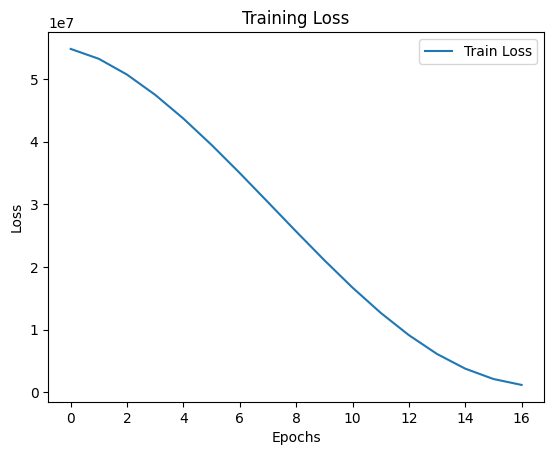

In [20]:
plt.plot(train_losses, label="Train Loss")
plt.legend()
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## 5. Save model

In [23]:
torch.save(model.state_dict(), "./flight_prediction_model.pt")